In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.display import Image
import os
import sys
os.chdir(r"/home/yuval/Documents/XNOR/sealnet-mlflow")

import cv2
from flow import s3_dataset, s3_cache
from noaadb import Session
from noaadb.schema.models import EOImage, HeaderMeta, IRLabelEntry, Species, IRImage, Flight
from flow.util import extract_util
import numpy as np

red=[255,0,0]
orange=[255,165,0]
yellow=[255,255,0]
green=[0,255,0]
blue=[0,0,255]
indigo=[75,0,130]
violet=[238,130,238]
COLORS = [red,orange,yellow,green,blue,indigo,violet]

def plot_im(im):
    import matplotlib.pyplot as plt
    # load image using cv2....and do processing.
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(im,  cmap='gray', vmin=0, vmax=255)
    # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()
    
# normalize IR
def min_max_norm(im):
    im_ir = ((im - np.min(im)) / (0.0 + np.max(im) - np.min(im)))
    im_ir = im_ir*255.0
    im_ir = im_ir.astype(np.uint8)
#     print(im_ir.min(), im_ir.max())
    return im_ir

def standardize(im):
    mu = im.mean()
    std = im.std()
    im = (im-mu)/std
    im[im<0] = 0
    im = im*255.0
    return im

def percentile(im):
    mi = np.percentile( im, 1 )
    ma = np.percentile( im, 100 )
    normalized = ( im - mi ) / ( ma - mi )
    normalized = normalized * 255
    normalized[ normalized < 0 ] = 0
    return normalized
    
        
def get_ir_for_all_flights():
    cams = extract_util.query_cfs(s,[],[],[])
    fl_cam_dict={}
    for cam in cams:
        if cam.cam_name == 'R':
            continue
        ir_images = s.query(IRImage).join(IRLabelEntry, IRLabelEntry.image_id == IRImage.file_name).join(Species).filter(Species.name.contains('Seal')).join(HeaderMeta)\
            .filter(HeaderMeta.camera_id == cam.id).all()
        fl_cam_dict[cam.flight.flight_name + '_' + cam.cam_name] = ir_images
    return fl_cam_dict

def read_ir(fp):
    im = cv2.imread(fp, cv2.IMREAD_ANYDEPTH)
    im_norm = min_max_norm(im)
    return im_norm

In [36]:
s = Session()
fl_dict = get_ir_for_all_flights()
fl_cutouts = {}
for cfl in fl_dict:
    fl_cutouts[cfl] = []
    print(len(fl_dict[cfl]))
    for im in fl_dict[cfl]:
        ir_im = read_ir(im.file_path)
        labels = s.query(IRLabelEntry).filter(IRLabelEntry.image_id == im.file_name).all()
        cutouts = []
        for l in labels:
            cutout = ir_im[l.y1:l.y2, l.x1:l.x2]
            fl_cutouts[cfl].append(cutout.flatten())
print(cfl)


    
s.close()

405
299
555
1043
695
557
268
206
fl06_C


fl05_L
322 labels extracted
77.0
95.60900275350174


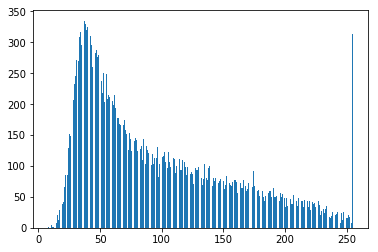

fl05_C
1105 labels extracted
122.0
130.80298379994127


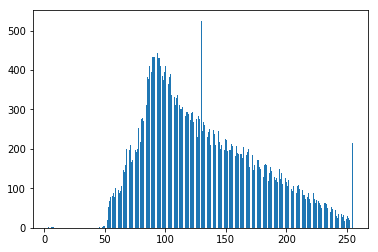

fl04_L
1482 labels extracted
75.0
93.2845182244677


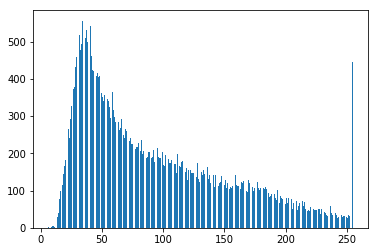

fl04_C
1627 labels extracted
111.0
123.59857923877843


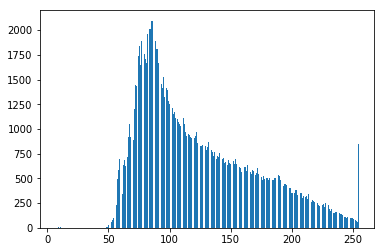

fl07_L
5191 labels extracted
73.0
90.13680645482617


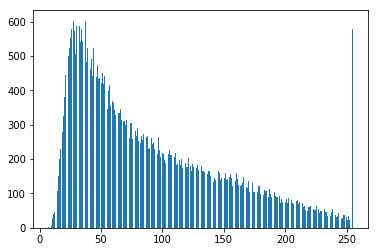

fl07_C
2134 labels extracted
102.0
117.88749941890195


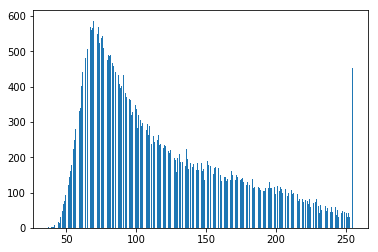

fl06_L
1663 labels extracted
62.0
87.56043838545844


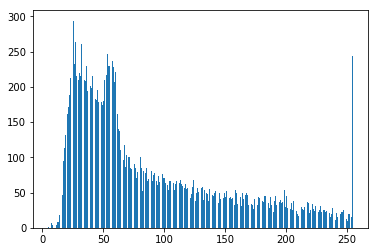

fl06_C
468 labels extracted
113.0
126.03922407645129


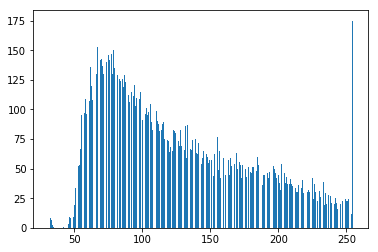

In [39]:
import matplotlib.pyplot as plt
vals = []
%matplotlib inline
for k in fl_cutouts:
    print(k)
    print('%d labels extracted'%len(cutouts))
    cutouts = np.array(fl_cutouts[k])
    flat_arr = np.concatenate(cutouts)
    print(np.median(flat_arr))
    print(np.mean(flat_arr))    
    hist, bins = np.histogram(flat_arr, bins=250)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()